In [2]:
# Ячейка 1: Импорты и настройка путей

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

# Библиотека с предобученными моделями
import timm

# Устанавливаем seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Timm version: ", timm.__version__)

# Определяем устройство (GPU, если доступен, иначе CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Настройка путей (так же, как в train.py, но адаптировано для ноутбука)
# Предполагаем, что ноутбук в папке 'notebooks', а данные в 'data' на одном уровне
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data" / "raw"
print(f"Project directory: {PROJECT_DIR}")
print(f"Data directory: {DATA_DIR}")

PyTorch Version:  2.8.0+cpu
Torchvision Version:  0.23.0+cpu
Timm version:  1.0.20
Using device: cpu
Project directory: C:\Users\yaden\PycharmProjects\ML_lab1\Fine_tuning
Data directory: C:\Users\yaden\PycharmProjects\ML_lab1\Fine_tuning\data\raw


In [3]:
# Ячейка 2: Трансформации и загрузка данных

# Задаем параметры
IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SPLIT = 0.2

# Трансформации данных
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Загружаем весь датасет
full_dataset = datasets.ImageFolder(DATA_DIR)

# Разделяем на train/val
num_data = len(full_dataset)
num_val = int(num_data * VAL_SPLIT)
num_train = num_data - num_val
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [num_train, num_val])

# Применяем нужные трансформации
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Создаем загрузчики
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes
num_classes = len(class_names)

print(f"Классы: {class_names}")
print(f"Количество классов: {num_classes}")
print(f"Размер обучающей выборки: {dataset_sizes['train']}")
print(f"Размер валидационной выборки: {dataset_sizes['val']}")

Классы: ['balls', 'cars', 'dogs']
Количество классов: 3
Размер обучающей выборки: 74
Размер валидационной выборки: 18


In [4]:
# Ячейка 3: Выбор, загрузка и адаптация моделей

# --- Модель 1: ResNet18 ---
model_resnet = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)
model_resnet = model_resnet.to(device)

print("Загружена модель ResNet18.")

# "Замораживаем" все слои
for param in model_resnet.parameters():
    param.requires_grad = False

# "Размораживаем" только последний слой (классификатор)
# У ResNet'ов в timm он называется 'fc' (fully connected)
for param in model_resnet.fc.parameters():
    param.requires_grad = True

# Проверим, что все сделано правильно
print("\nПараметры ResNet18 для обучения:")
total_params_resnet = sum(p.numel() for p in model_resnet.parameters())
trainable_params_resnet = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params_resnet}")
print(f"Обучаемых параметров (только 'голова'): {trainable_params_resnet}")


# --- Модель 2: EfficientNet_B0 ---
model_effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model_effnet = model_effnet.to(device)

print("\n" + "="*50)
print("Загружена модель EfficientNet_B0.")

# "Замораживаем" все слои
for param in model_effnet.parameters():
    param.requires_grad = False

# "Размораживаем" только последний слой
# У EfficientNet'ов в timm он называется 'classifier'
for param in model_effnet.classifier.parameters():
    param.requires_grad = True

# Проверим, что все сделано правильно
print("\nПараметры EfficientNet_B0 для обучения:")
total_params_effnet = sum(p.numel() for p in model_effnet.parameters())
trainable_params_effnet = sum(p.numel() for p in model_effnet.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params_effnet}")
print(f"Обучаемых параметров (только 'голова'): {trainable_params_effnet}")

Загружена модель ResNet18.

Параметры ResNet18 для обучения:
Всего параметров: 11178051
Обучаемых параметров (только 'голова'): 1539

Загружена модель EfficientNet_B0.

Параметры EfficientNet_B0 для обучения:
Всего параметров: 4011391
Обучаемых параметров (только 'голова'): 3843


In [5]:
# Ячейка 4: Универсальная функция для обучения модели

from tqdm.notebook import tqdm # Для красивого progress bar

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Сохраняем лучшие веса модели
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Словари для хранения истории обучения
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Каждая эпоха имеет фазу обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установить модель в режим обучения
            else:
                model.eval()   # Установить модель в режим оценки

            running_loss = 0.0
            running_corrects = 0

            # Итерация по данным
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуляем градиенты
                optimizer.zero_grad()

                # Прямой проход (forward)
                # Отслеживаем историю только в фазе обучения
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Сохраняем метрики в историю
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            # Глубокое копирование модели, если она лучшая
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Загружаем лучшие веса
    model.load_state_dict(best_model_wts)
    return model, history

In [6]:
# Ячейка 5: Обучение модели ResNet18

# 1. Задаем функцию потерь
criterion = nn.CrossEntropyLoss()

# 2. Создаем оптимизатор. Обратите внимание, что мы передаем в него
# только обучаемые параметры нашей модели (голову).
params_to_update_resnet = [p for p in model_resnet.parameters() if p.requires_grad]
optimizer_resnet = optim.Adam(params_to_update_resnet, lr=0.001)

# 3. Настраиваем планировщик скорости обучения
# Будем уменьшать lr в 0.1 раза каждые 7 эпох
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

# 4. Запускаем обучение!
NUM_EPOCHS = 10 
trained_resnet, history_resnet = train_model(
    model_resnet, 
    criterion, 
    optimizer_resnet, 
    exp_lr_scheduler_resnet, 
    num_epochs=NUM_EPOCHS
)

Epoch 1/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.0589 Acc: 0.4730


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.0891 Acc: 0.3889

Epoch 2/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.9193 Acc: 0.7297


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9843 Acc: 0.5556

Epoch 3/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.8238 Acc: 0.8108


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8747 Acc: 0.6667

Epoch 4/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.7444 Acc: 0.8919


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7956 Acc: 0.9444

Epoch 5/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.6513 Acc: 0.9595


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7033 Acc: 1.0000

Epoch 6/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5313 Acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6263 Acc: 1.0000

Epoch 7/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5163 Acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5780 Acc: 1.0000

Epoch 8/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4495 Acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5619 Acc: 1.0000

Epoch 9/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4605 Acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5519 Acc: 1.0000

Epoch 10/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4529 Acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5413 Acc: 1.0000

Training complete in 1m 28s
Best val Acc: 1.000000


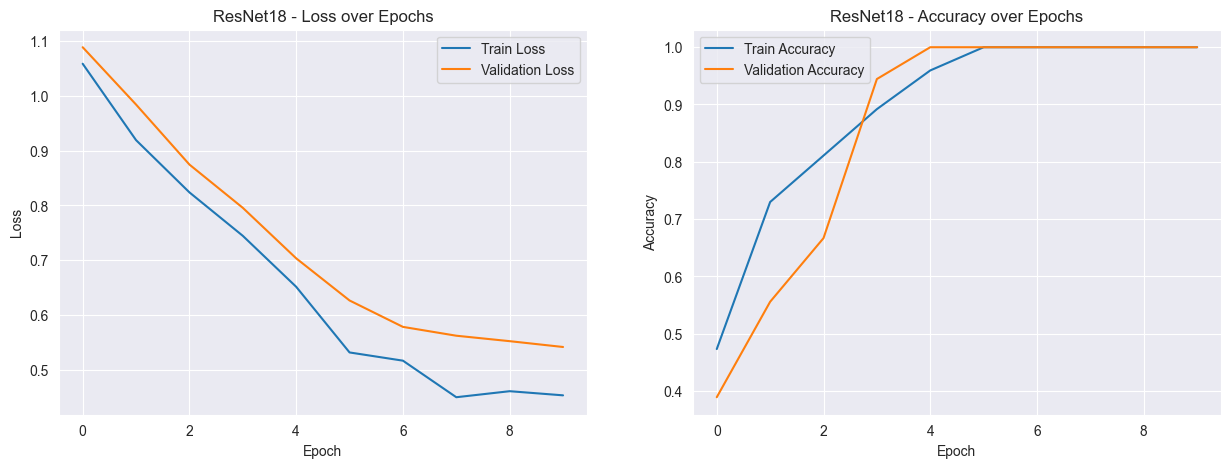

In [7]:
# Ячейка 6: Визуализация результатов обучения ResNet18

def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График потерь (Loss)
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # График точности (Accuracy)
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_history(history_resnet, "ResNet18")

# Ячейка 7: Обучение модели EfficientNet_B0

In [8]:
# Создаем оптимизатор для EfficientNet_B0
params_to_update_effnet = [p for p in model_effnet.parameters() if p.requires_grad]
optimizer_effnet = optim.Adam(params_to_update_effnet, lr=0.001)

# Настраиваем планировщик
exp_lr_scheduler_effnet = lr_scheduler.StepLR(optimizer_effnet, step_size=7, gamma=0.1)

# Запускаем обучение EfficientNet_B0
trained_effnet, history_effnet = train_model(
    model_effnet, 
    criterion, 
    optimizer_effnet, 
    exp_lr_scheduler_effnet, 
    num_epochs=NUM_EPOCHS
)

Epoch 1/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 4.4254 Acc: 0.3378


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.8567 Acc: 0.4444

Epoch 2/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 3.3855 Acc: 0.4189


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7432 Acc: 0.5000

Epoch 3/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 2.7429 Acc: 0.4459


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6904 Acc: 0.5000

Epoch 4/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 2.4872 Acc: 0.4459


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6960 Acc: 0.5000

Epoch 5/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 2.1690 Acc: 0.5811


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7103 Acc: 0.5000

Epoch 6/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 2.1073 Acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7936 Acc: 0.4444

Epoch 7/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.7713 Acc: 0.5811


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6625 Acc: 0.4444

Epoch 8/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.4920 Acc: 0.5541


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6352 Acc: 0.4444

Epoch 9/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.2702 Acc: 0.6351


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6300 Acc: 0.4444

Epoch 10/10
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.5421 Acc: 0.5811


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6728 Acc: 0.4444

Training complete in 1m 21s
Best val Acc: 0.500000


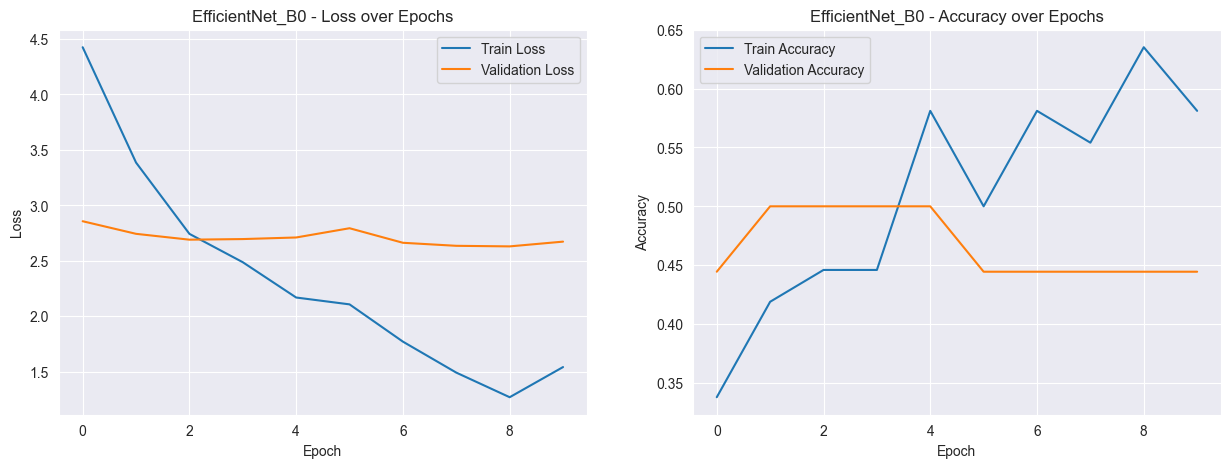

In [9]:
# Ячейка 8: Визуализация результатов обучения EfficientNet_B0

plot_history(history_effnet, "EfficientNet_B0")

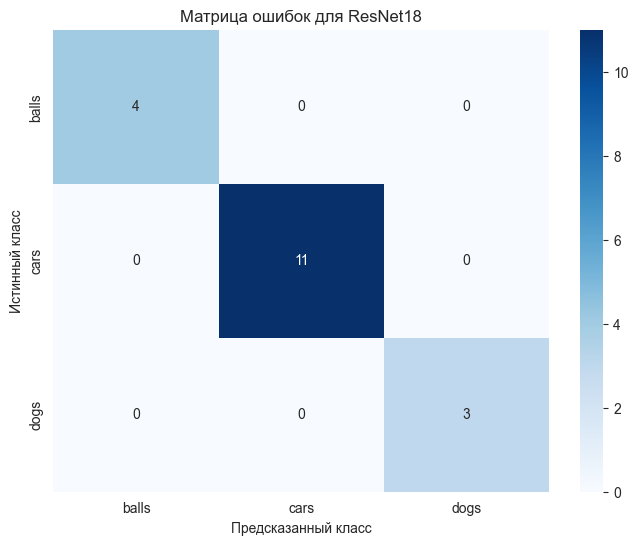

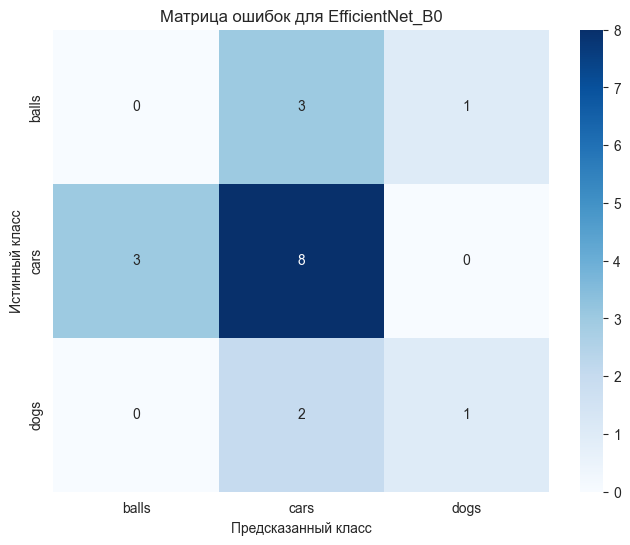

In [10]:
# Ячейка 9: Функция для построения матрицы ошибок

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(model, model_name):
    model.eval() # Переводим модель в режим оценки
    
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Переносим на CPU для работы с sklearn
    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()

    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Матрица ошибок для {model_name}')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

# Строим матрицу для ResNet18
plot_confusion_matrix(trained_resnet, "ResNet18")

# После обучения EfficientNet_B0, вы сможете построить матрицу и для него:
plot_confusion_matrix(trained_effnet, "EfficientNet_B0")